# Wildfire Risk - Model - Script-based Approach
__Team 3 - Dave Friesen, John Chen, and Kyle Dalope__<br>
__ADS-508-02-SP23__<br><br>
__GitHub link: https://github.com/davefriesen/wildfire-risk__

In [1]:
__authors__ = ['Dave Friesen', 'John Chen', 'Kyle Dalope']
__contact__ = ['dfriesen@sandiego.edu', 'johnchen@sandiego.edu', 'kdalope@sandiego.edu']
__date__ = '2023-03-20'
__license__ = 'MIT'
__version__ = '1.0.1'

In [2]:
cloud = False
%store cloud

Stored 'cloud' (bool)


# Setup

In [3]:
# Import basic libraries
if cloud:
    import boto3
    import sagemaker

# Import basic and data access libraries
import numpy as np
import pandas as pd
from profiler import profile, profile_cat

# Import model and performance evaluation libraries
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.neural_network import MLPClassifier

# Import custom model library
from model_process import ModelProcess

# Import utility libraries
import copy

In [4]:
if cloud:
    # Establish session fundamentals
    sess = sagemaker.Session()
    bucket = sess.default_bucket()
    role = sagemaker.get_execution_role()
    region = boto3.Session().region_name
    account_id = boto3.Session().client(service_name='sagemaker', region_name=region)

    # Re-confirm public and private paths
    s3_public_path = 's3://wildfire-risk/'
    %store s3_public_path
    s3_private_path = 's3://{}/widfire-risk/csv/'.format(bucket)
    %store s3_private_path

    # Re-copy public bucket-based data to private (local) bucket
    #!aws s3 cp --recursive $s3_public_path $s3_private_path'fires'/ --exclude '*' --include 'fires.csv'
    #!aws s3 cp --recursive $s3_public_path $s3_private_path'weather'/ --exclude '*' --include 'weather.csv'
    #!aws s3 cp --recursive $s3_public_path $s3_private_path'conditions'/ --exclude '*' --include 'conditions.csv'
    #!aws s3 cp --recursive $s3_public_path $s3_private_path'merged'/ --exclude '*' --include 'merged.csv'    

# Data Load

In [5]:
if cloud:
    df = pd.read_csv(s3_private_path+'merged/merged.csv', low_memory=False)
else:
    df = pd.read_csv('../data/merged.csv', low_memory=False)

# Data Profiling and Pre-Processing

## Target and Feature Identification (preliminary)

In [6]:
# Preliminarily elimate n/a features - in this case, extraneous from target 'fires' dataset
df = df.drop(columns=[
    'ContainmentDateTime',
    'ControlDateTime',
    'DiscoveryAcres',
    'EstimatedCostToDate',
    'FinalAcres',
    'FireCause',
    'FireBehaviorGeneral',
    'FireBehaviorGeneral1',
    'FireBehaviorGeneral2',
    'FireBehaviorGeneral3',
    'FireCauseGeneral',
    'FireCauseSpecific',
    'FireDiscoveryDateTime',
    'FireOutDateTime',
    'GACC',
    'IncidentName',
    'IncidentShortDescription',
    'InitialLatitude',
    'InitialLongitude',
    'IsFireCauseInvestigated',
    'IsTrespass',
    'POOCity',
    'POOState',
    'PredominantFuelModel',
    'PrimaryFuelModel',
    'ym_date'    
])

pd.set_option('display.max_rows', 100)
profile(df)

,Dtype,count,unique,na,na%,mean,std,min,max,skew(>=3),<v0.01,VIF(>=10),examples
STATION,object,42289,418,,,,,,,,,,USR0000OCAI__USR0000
LATITUDE,float64,42289,416,,,40.9,4.3,32.6,49.0,,,3364.2,42.6314__43.6806__34
LONGITUDE,float64,42289,409,,,-120.7,2.2,-124.3,-114.5,,,205.0,-121.5597__-122.3019
ELEVATION,float64,42289,332,,,1046.3,542.1,,2748.7,,,,2020.5__1028.1__883.
NAME,object,42289,418,,,,,,,,,,"CALIMUS OREGON, OR U"
CDSD,float64,39981,4742,2308,5.5,192.8,296.7,,3200.5,,,,180.5__0.0__1288.7__
CDSD_ATTRIBUTES,object,39577,1,2712,6.4,,,,,,,,U__U__U__U__U
CLDD,float64,42241,2473,48,0.1,38.3,69.0,,566.7,,,27.3,0.0__0.0__0.0__0.0__
CLDD_ATTRIBUTES,object,42241,6,48,0.1,,,,,,,,"2,U__,U__,U__,U__,U"
DT00,float64,42279,15,10,,0.1,0.6,,17.0,14.6,,,0.0__0.0__0.0__0.0__


In [7]:
# Identify column types and feature set, including for pipeline treeatment
ignore_cols = ['STATION', 'LATITUDE', 'LONGITUDE', 'NAME', 'geohash', 'year', 'month', 'PLT_CN',
               'STATE', 'LAT', 'LON', 'FireCause']

cat_nominal_cols = ['CDSD_ATTRIBUTES', 'CLDD_ATTRIBUTES', 'DT00_ATTRIBUTES', 'DT32_ATTRIBUTES',
                    'DX32_ATTRIBUTES', 'DX70_ATTRIBUTES', 'DX90_ATTRIBUTES', 'EMNT_ATTRIBUTES',
                    'EMXT_ATTRIBUTES', 'HDSD_ATTRIBUTES', 'HTDD_ATTRIBUTES', 'TAVG_ATTRIBUTES',
                    'TMAX_ATTRIBUTES', 'TMIN_ATTRIBUTES']
cat_ordinal_cols = []
cat_binary_cols = []

num_interval_cols = ['COND_STATUS_CD']
num_ratio_cols = ['ELEVATION', 'CDSD', 'CLDD', 'DT00', 'DT32', 'DX32', 'DX70', 'DX90',
                  'EMNT', 'EMXT', 'HDSD', 'HTDD', 'TAVG', 'TMAX', 'TMIN', 'MAPDEN',
                  'STDAGE', 'STDSZCD', 'FLDSZCD', 'SITECLCD', 'SICOND', 'STDORGCD',
                  'SLOPE', 'PHYSCLCD', 'GSSTKCD', 'DSTRBCD1', 'TRTCD1', 'PRESNFCD',
                  'FLDAGE', 'CARBON_DOWN_DEAD', 'CARBON_LITTER', 'CARBON_SOIL_ORG',
                  'CARBON_STANDING_DEAD', 'CARBON_UNDERSTORY_AG', 'CARBON_UNDERSTORY_BG',
                  'WATERCD']

target_cls_col = ['fire']

reduce_X_cols = ignore_cols + target_cls_col

# Data Partitioning

In [8]:
df_X = df.loc[:, ~df.columns.isin(reduce_X_cols)].copy()
df_y = df[target_cls_col]

In [9]:
train_ratio = 0.7; val_ratio = 0.20; test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, test_size=1-train_ratio, 
    random_state=42, stratify=df_y)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=test_ratio/(test_ratio+val_ratio),
    random_state=42, stratify=y_test)

trows = df_X.shape[0]
print('\nTrain/validation/test: ', X_train.shape[0], '/', X_val.shape[0], '/', X_test.shape[0])

profile_cat(y_train, target_cls_col)


Train/validation/test:  29602 / 8458 / 4229

fire - 
 0.0  76.991419
 1.0  23.008581


# Modeling

## Model Setup (selection)

In [10]:
# Set feature cols for appropriate pipeline preprocessing
cat_cols = cat_nominal_cols + cat_ordinal_cols + cat_binary_cols  # one-hot encoding, imputing (if necc)
num_cols = num_interval_cols + num_ratio_cols  # scaling, imputing (if necc)

In [24]:
# Set model list
mp_queue = (
    (LogisticRegression(), {'C': 0.01, 'class_weight': 'balanced', 'random_state': 42}),
    (LogisticRegression(), {'C': 0.1, 'class_weight': 'balanced', 'random_state': 42}),
    (LogisticRegression(), {'C': 1.0, 'class_weight': 'balanced', 'random_state': 42}),

    (Perceptron(), {'alpha': 0.01, 'class_weight': 'balanced'}),
    (Perceptron(), {'alpha': 0.1, 'class_weight': 'balanced'}),
    (Perceptron(), {'alpha': 1.0, 'class_weight': 'balanced'}),

    (LinearDiscriminantAnalysis(), None),
    
    (LinearSVC(), {'C': 0.01, 'class_weight': 'balanced', 'random_state': 42}),
    (LinearSVC(), {'C': 0.1, 'class_weight': 'balanced', 'random_state': 42}),
    (LinearSVC(), {'C': 1.0, 'class_weight': 'balanced', 'random_state': 42}),

    (KNeighborsClassifier(), {'n_neighbors': 3}),
    (KNeighborsClassifier(), {'n_neighbors': 5}),
    (KNeighborsClassifier(), {'n_neighbors': 7}),

    (DecisionTreeClassifier(), {'max_depth': 4, 'random_state': 42}),
    (DecisionTreeClassifier(), {'max_depth': 5, 'random_state': 42}),
    (DecisionTreeClassifier(), {'max_depth': 6, 'random_state': 42}),

    (RandomForestClassifier(), {'max_depth': 4, 'random_state': 42}),
    (RandomForestClassifier(), {'max_depth': 5, 'random_state': 42}),
    (RandomForestClassifier(), {'max_depth': 6, 'random_state': 42}),

    (AdaBoostClassifier(), {'n_estimators': 10, 'random_state': 42}),
    (AdaBoostClassifier(), {'n_estimators': 30, 'random_state': 42}),
    (AdaBoostClassifier(), {'n_estimators': 50, 'random_state': 42}),

    (MLPClassifier(), {'alpha': 0.0001, 'random_state': 42}),
    (MLPClassifier(), {'alpha': 0.001, 'random_state': 42}),
    (MLPClassifier(), {'alpha': 0.01, 'random_state': 42})
)

## Model Run and Evaluation (iteration n)

In [25]:
ModelProcess.show_progress = True

# Iterate models (note use of 'copy' is to preserve mutable elements
#   of model_queue tuple for possible later use)
mp_df = pd.DataFrame(mp_queue, columns=['algorithm', 'params'])
mp_df['mp'] = mp_df.apply(
    lambda mp: ModelProcess(copy.deepcopy(mp['algorithm']), None,
                            copy.copy(mp['params']),
                            X_train, y_train,
                            X_val, y_val,
                            X_test, y_test,
                            None,
                            cat_cols, num_cols,
                            balance_target=True).train_validate_test(), axis=1)

# Compile, sort, and display results
mp_df[['train_acc', 'train_f1', 'train_time',
       'val_acc', 'val_f1', 'val_time',
       'test_acc', 'test_f1', 'test_time']] =\
    mp_df['mp'].apply(
        lambda mp: sum(list(map(
            lambda dataset: mp.score[dataset] + [mp.time[dataset]], ['train', 'val', 'test'])), [])).tolist()
mp_df.sort_values(by=['train_f1', 'val_f1', 'test_f1'],
                  ascending=[False, False, False], inplace=True)
mp_df.loc[:, mp_df.columns != 'mp'].to_csv('results_table.csv')

LogisticRegression: train... done in 1.75s.
LogisticRegression: val... done in 0.07s.
LogisticRegression: test... done in 0.04s.
LogisticRegression: train... done in 1.73s.
LogisticRegression: val... done in 0.07s.
LogisticRegression: test... done in 0.04s.
LogisticRegression: train... done in 1.86s.
LogisticRegression: val... done in 0.07s.
LogisticRegression: test... done in 0.04s.
Perceptron: train... done in 0.87s.
Perceptron: val... done in 0.04s.
Perceptron: test... done in 0.02s.
Perceptron: train... done in 0.87s.
Perceptron: val... done in 0.04s.
Perceptron: test... done in 0.02s.
Perceptron: train... done in 0.87s.
Perceptron: val... done in 0.04s.
Perceptron: test... done in 0.02s.
LinearDiscriminantAnalysis: train... done in 2.95s.
LinearDiscriminantAnalysis: val... done in 0.07s.
LinearDiscriminantAnalysis: test... done in 0.04s.
LinearSVC: train... done in 8.54s.
LinearSVC: val... done in 0.04s.
LinearSVC: test... done in 0.02s.
LinearSVC: train... done in 11.43s.
LinearS

In [26]:
mp_df

,algorithm,params,mp,train_acc,train_f1,train_time,val_acc,val_f1,val_time,test_acc,test_f1,test_time
22,MLPClassifier(),"{'alpha': 0.0001, 'random_state': 42}",<model_process.ModelProcess object at 0x7f8b89...,0.998683,0.997138,158.712695,0.892882,0.774515,0.105630,0.902341,0.792982,0.065128
23,MLPClassifier(),"{'alpha': 0.001, 'random_state': 42}",<model_process.ModelProcess object at 0x7f8b89...,0.998615,0.996990,124.368743,0.894538,0.775202,0.099573,0.906361,0.798985,0.065388
24,MLPClassifier(),"{'alpha': 0.01, 'random_state': 42}",<model_process.ModelProcess object at 0x7f8b89...,0.994663,0.988449,96.274308,0.891582,0.771720,0.104963,0.903760,0.795785,0.059434
10,KNeighborsClassifier(),{'n_neighbors': 3},<model_process.ModelProcess object at 0x7f8b68...,0.924296,0.856759,17.969983,0.824545,0.682363,5.265954,0.816505,0.672574,2.643877
11,KNeighborsClassifier(),{'n_neighbors': 5},<model_process.ModelProcess object at 0x7f8b89...,0.867914,0.768913,17.420922,0.793332,0.649137,5.289987,0.790731,0.649505,2.660997
12,KNeighborsClassifier(),{'n_neighbors': 7},<model_process.ModelProcess object at 0x7f8b68...,0.834606,0.721375,17.616339,0.780326,0.633819,5.628002,0.775834,0.631128,2.691399
21,AdaBoostClassifier(),"{'n_estimators': 50, 'random_state': 42}",<model_process.ModelProcess object at 0x7f8b89...,0.734748,0.578846,10.802740,0.726176,0.569996,0.368713,0.740837,0.588589,0.194436
15,DecisionTreeClassifier(),"{'max_depth': 6, 'random_state': 42}",<model_process.ModelProcess object at 0x7f8b89...,0.715898,0.575510,1.107208,0.707732,0.567378,0.068507,0.714590,0.570004,0.037913
20,AdaBoostClassifier(),"{'n_estimators': 30, 'random_state': 42}",<model_process.ModelProcess object at 0x7f8b89...,0.726302,0.567155,6.676939,0.714590,0.555269,0.245206,0.736581,0.584948,0.131757
14,DecisionTreeClassifier(),"{'max_depth': 5, 'random_state': 42}",<model_process.ModelProcess object at 0x7f8b89...,0.717147,0.561921,1.030411,0.708915,0.555435,0.069253,0.719083,0.560000,0.037926


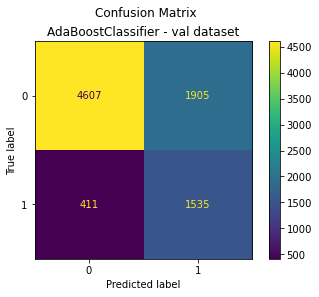



AdaBoostClassifier - val dataset

              precision    recall  f1-score   support

         0.0       0.92      0.71      0.80      6512
         1.0       0.45      0.79      0.57      1946

    accuracy                           0.73      8458
   macro avg       0.68      0.75      0.68      8458
weighted avg       0.81      0.73      0.75      8458



In [27]:
# Show confusion matrix and summary for ADABoost
mp_df.loc[21]['mp'].confusion_matrix('val')
mp_df.loc[21]['mp'].summary('val')

In [30]:
# Show top features for Logistic Regression (this could be 'baked' into the
#   ModelProcess() class or similar in future)
#model = mp_df.loc[21]['mp'].model
#features = mp_df.loc[21]['mp'].pipe['preprocessor'].transformers_[0][1]['onehotencoder'].get_feature_names_out(cat_cols)
#fi = pd.concat([pd.DataFrame(features, columns=['feature']),
#                pd.DataFrame(num_cols, columns=['feature'])],
#               ignore_index=True)

#fi['importance'] = model.coef_[0]
#fi['abs_importance'] = abs(fi['importance'])
#fi.sort_values(by=['abs_importance', 'feature'],
#               ascending=[False, True], inplace=True)
#fi[fi['abs_importance'] >= 0.50][['feature', 'importance']]

# Store Variables and Close Session

In [20]:
# Store variables for subsequent notebooks
%store

Stored variables and their in-db values:
cloud                     -> False
local_Jupyter             -> True


In [21]:
#%%html

#<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
#<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
#<script>
#try {
#    els = document.getElementsByClassName("sm-command-button");
#    els[0].click();
#}
#catch(err) {
#    // NoOp
#}    
#</script>

In [ ]:
# %%javascript

#try {
#    Jupyter.notebook.save_checkpoint();
#    Jupyter.notebook.session.delete();
#}
#catch(err) {
#    // NoOp
#}

<IPython.core.display.Javascript object>